## Setup

In [1]:
# boilerplate code
import os
from io import BytesIO
import numpy as np
import time
import PIL.Image
from IPython.display import clear_output, Image, display
from __future__ import print_function

import tensorflow as tf

model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

with tf.gfile.FastGFile(model_fn, 'rb') as f:
    # create an empty GraphDef object; this is the object we'll populate w/ data from the file
    graph_def = tf.GraphDef()
    # read binary data (different protocol for textual GraphDef objects); graph_def now contains
    # operations to be imported into the default graph
    graph_def.ParseFromString(f.read())
    
# define the input tensor
t_input = tf.placeholder(np.float32, name='input') 
# ?
imagenet_mean = 117.0
# subtract mean from all input data
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
# import graph_def into the Python Graph; second argument is dictionary mapping input names in
# graph_def to Tensor objects
tf.import_graph_def(graph_def, {'input':t_preprocessed})

## Helper Functions

In [2]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    # create an empty (?) file object
    f = BytesIO()
    # save array to file object
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("%s:0"%layer)

# Helper functions that use TF to resize an image
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)

def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

def stdize(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

## Deep Dream

In [3]:
def render_deepdream(t_obj, img0, disp=True,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image into a number of octaves
    img = img0
    octaves = []
    if disp:
        print("Splitting image into octaves ...")
        
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
            
#         if octave == 0:
#             iters = 1 * iter_n
#         elif octave == 1:
#             iters = 1 * iter_n
#         elif octave == octave_n - 2:
#             iters = iter_n / 1
#         elif octave == octave_n - 1:
#             iters = 0 #iter_n / 1
                
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            if disp:
                print('.',end = ' ')

        if disp:
            clear_output()
            showarray(img/255.0)
        
    return img

## Single Filter Example

In [97]:
# get network info
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
features = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

# import image
img_base = PIL.Image.open('/media/data/Dropbox/deep-dream/source/snow/sierra_in_snow.jpg')
img_base = np.float32(img_base)
img0 = img_base

# user variables
saving = 1                 # 1 to save
layer_nums = [10, 10] 
feature_nums = [0, 121]
num_frames = 320           # number of frames for transition from one filter to the next
num_frames_cutoff = 4      # get rid of a certain number of beginning frames (more variation here)

T_layers = []
for layer_num in layer_nums:
    T_layers.append(layers[layer_num])
    
weights = []
temp = np.linspace(0.0, 1.0, num=num_frames)
temp = np.append(temp, np.ones(np.floor(num_frames/321))) # quotient of 8-10 usually works well
weights.append(temp)
temp = 1.0 - temp
weights.append(temp)

for i in range(weights[0].size):
    
    print("\rFrame %03i of %03i" % (i+1, weights[0].size), end="")
    
    # for consistency between frames
    np.random.seed(0)
    
    # run deep dream
    img = render_deepdream(weights[0][i]*T(T_layers[0])[:,:,:,feature_nums[0]] + \
                           weights[1][i]*T(T_layers[1])[:,:,:,feature_nums[1]], \
                           img0, iter_n=10, octave_n=4, disp=False, octave_scale=1.4)
    
    base_multiplier = 0.5
    # 0.1 - large increase in color saturation, good stability of features
    # 0.5 - decent tradeoff between saturation and stability
    # 0.9 - color saturation stays nice, stability of features pretty bad

    # use a convex combination of base image and previous output to maintain feature continuity
    img0 = (1-base_multiplier)*img + base_multiplier*img_base
    
    # save output
    if saving & (i >= num_frames_cutoff) & (i % 1 == 0):
        dir_path = '/home/mattw/Desktop/test_sierra'  
        feature_name = 'frame_%03i.jpg' % i
        file_path = '/'.join([dir_path, feature_name])
        img = np.uint8(np.clip(img, 0, 255)) 
        PIL.Image.fromarray(img).save(file_path, 'jpeg')
        
print('\n\nDone!')

# to make a gif:
# cd to the directory containing the images
#   mogrify -despeckle *.jpg
#   convert -delay 5x120 -loop 0 *.jpg animated.gif
#   convert animated.gif -coalesce -duplicate 1,-2-1 -quiet -layers OptimizePlus -loop 0 cycle.gif
#
# osa_island.gif
# 32/26, 22/101, num_frames=160, num_frames_cutoff=50, append divisor=8, base_multiplier=0.5, save every 2 frames
# iter_n=40, octave_n=4, octave_scale=1.4
#
# sierra_in_snow.gif
# 10/0, 10/121, num_frames=80, num_frames_cutoff=4, append divisor=10, base_multiplier=0.5, save every 2 frames
# iter_n=10, octave_n=4, octave_scale=1.4

Frame 320 of 320

Done!


## ImageMagick Commands

### to downsample a single image:
convert {source} -resize X% {output}

### to batch downsample an entire directory:
mogrify -path full/path/to/temp -resize 60x60% -quality 60 -format jpg *.png
take all pngs in current directory, resize them by 60%, set quality to 60, format to jpg, and output to full/path/to/temp

### to batch denoise an entire directory
mogrify -despeckle *.jpg
### for a single image
convert -despeckle image.jpg new_image.jpg

### create gif:
convert -delay 4x120 -loop 0 *.jpg animated.gif
take all jpgs in current directory and turn them into a gif that loops indefinitely, with a framerate of 120/4 = 30 fps

### set up patrol cycle
convert animated.gif -coalesce -duplicate 1,-2-1 -quiet -layers OptimizePlus -loop 0 cycle.gif
no idea what's really going on here. Takes "animated.gif" and duplicates all frames once except first and last (that's somehow encoded in 1,-2-1), loops the result indefintely, and outputs to cycle.gif

## Single Filter playground

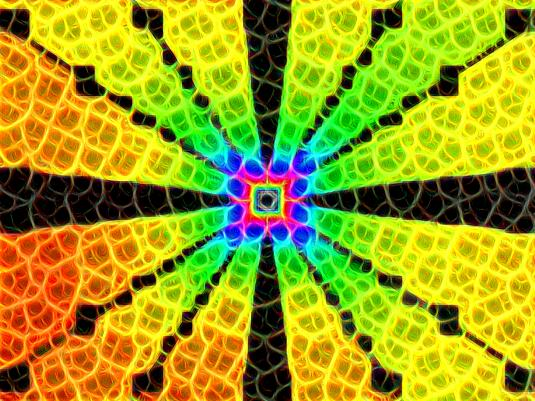

In [96]:
# get network info
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
features = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

# import image
# to downsample with ImageMagick: convert {source} -resize X% {output}
# img0 = PIL.Image.open('/home/mattw/Dropbox/deep-dream/source/trees/osa_island.jpg')
# img0 = PIL.Image.open('/media/data/Dropbox/deep-dream/source/snow/sierra_in_snow.jpg')
img0 = PIL.Image.open('/media/data/Dropbox/deep-dream/source/abstract/tubes_01.jpg')
img0 = np.float32(img0)
showarray(img0/255.0)

layer = layers[10]
feature_num = 0
# tubes_00 - 10/10, 20/9, 26/22, 28/27, 22/101, 14/55, *20/37*
# tubes_01 - 14/38, 22/11, 22/62, *10/0*, 10/65
# run deep dream; more iterations intensifies features, more octaves increases their size
img = render_deepdream(T(layer)[:,:,:,feature_num], img0, iter_n=40, octave_n=4, octave_scale=1.4)